<a href="https://colab.research.google.com/github/TakuroTerui/object_gan_autoencoder_image/blob/master/%E5%A4%89%E5%88%86%E3%82%AA%E3%83%BC%E3%83%88%E3%82%A8%E3%83%B3%E3%82%B3%E3%83%BC%E3%83%80%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x.view(-1)
])

mnist_train = torchvision.datasets.MNIST(
    root='content/drive/MyDrive/Colab Notebooks/Autoencoder/VAE_PyTorch/mnist_root',
    download=True,
    train=True,
    transform=transform
)

mnist_test = torchvision.datasets.MNIST(
    root='content/drive/MyDrive/Colab Notebooks/Autoencoder/VAE_PyTorch/mnist_root',
    download=True,
    train=False,
    transform=transform
)

train_dataloader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=1, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 129392375.84it/s]


Extracting content/drive/MyDrive/Colab Notebooks/Autoencoder/VAE_PyTorch/mnist_root/MNIST/raw/train-images-idx3-ubyte.gz to content/drive/MyDrive/Colab Notebooks/Autoencoder/VAE_PyTorch/mnist_root/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 31578648.03it/s]


Extracting content/drive/MyDrive/Colab Notebooks/Autoencoder/VAE_PyTorch/mnist_root/MNIST/raw/train-labels-idx1-ubyte.gz to content/drive/MyDrive/Colab Notebooks/Autoencoder/VAE_PyTorch/mnist_root/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41958995.28it/s]

Extracting content/drive/MyDrive/Colab Notebooks/Autoencoder/VAE_PyTorch/mnist_root/MNIST/raw/t10k-images-idx3-ubyte.gz to content/drive/MyDrive/Colab Notebooks/Autoencoder/VAE_PyTorch/mnist_root/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 9435625.94it/s]


Extracting content/drive/MyDrive/Colab Notebooks/Autoencoder/VAE_PyTorch/mnist_root/MNIST/raw/t10k-labels-idx1-ubyte.gz to content/drive/MyDrive/Colab Notebooks/Autoencoder/VAE_PyTorch/mnist_root/MNIST/raw



In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
import torch.nn.functional as F
import torch.nn as nn

class VariationalEncoder(nn.Module):
    '''エンコーダー
    Attributes:
        device:使用するデバイス
        l1:全結合層
        l_mean:全結合層（平均値を出力する層）
        l_var:全結合層（分散を出力する層）
    '''
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(784, 200)
        self.l_mean = nn.Linear(200, 10)
        self.l_var = nn.Linear(200, 10)

    def forward(self, x):
        h = self.l1(x)
        h = torch.relu(h)
        mean = self.l_mean(h)
        var = self.l_var(h)
        var = F.softplus(var)

        return mean, var

In [5]:
class VariationalDecoder(nn.Module):
    '''デコーダー
    Attributes:
        device:使用するデバイス
        l1:全結合層(200)
        l2:全結合層(784)
    '''
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(10, 200)
        self.l2 = nn.Linear(200, 784)

    def forward(self, x):
        h = self.l1(x)
        h = torch.relu(h)
        h = self.l2(h)
        y = torch.sigmoid(h)

        return y

In [7]:
class VAE(nn.Module):
    '''変分オートエンコーダー
    Attributes:
        device:使用するデバイス
        encode:エンコーダーのモデル
        decode:デコーダーのモデル
    '''
    def __init__(self, device='cpu'):
        '''deviceを設置し、エンコーダーとデコーダーのモデルを生成する
        '''
        super().__init__()
        self.device = device
        self.encoder = VariationalEncoder(device=device)
        self.decoder = VariationalDecoder(device=device)
    
    def forward(self, x):
        '''順伝播処理
        '''
        mean, var = self.encoder(x)
        z = self.latent_variable(mean, var)
        y = self.decoder(z)
        return y, z
    
    def latent_variable(self, mean, var):
        '''潜在変数を作成する
        '''
        # 平均0、分散1の標準正規分布からl_meanの出力値の数だけサンプリング
        eps = torch.randn(mean.size()).to(self.device)
        z = mean + torch.sqrt(var) * eps
        return z
    
    def lower_bound(self, x):
        '''損失関数
        再構築ロスと潜在ロスの合計を求める
        '''
        mean, var = self.encoder(x)
        z = self.latent_variable(mean, var)
        y = self.decoder(z)
        # 再構築ロス
        reconst_loss = - torch.mean(
            torch.sum(x * torch.log(y) + (1 - x) * torch.log(1 -y), dim=1))
        # 潜在ロス
        latent_loss = - 1/2 * torch.mean(
            torch.sum(1 + torch.log(var) - mean ** 2 - var, dim=1))
        # 再構築ロス＋潜在ロス
        loss = reconst_loss + latent_loss
        return loss

In [8]:
import torch.optim as optimizers

# 変分オートエンコーダーを生成
model = VAE(device=device).to(device)
# VAEの損失関数を設定
criterion = model.lower_bound
# オプティマイザーをAdamに設定
optimizer = optimizers.Adam(model.parameters())

print(model)

VAE(
  (encoder): VariationalEncoder(
    (l1): Linear(in_features=784, out_features=200, bias=True)
    (l_mean): Linear(in_features=200, out_features=10, bias=True)
    (l_var): Linear(in_features=200, out_features=10, bias=True)
  )
  (decoder): VariationalDecoder(
    (l1): Linear(in_features=10, out_features=200, bias=True)
    (l2): Linear(in_features=200, out_features=784, bias=True)
  )
)


In [9]:
%%time

epochs = 10
for epoch in range(epochs):
    train_loss = 0.
    for (x, _) in train_dataloader:
        x = x.to(device)
        model.train()
        loss = criterion(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    print('Epoch({}) -- Loss: {:.3f}'.format(epoch+1, train_loss))

Epoch(1) -- Loss: 155.947
Epoch(2) -- Loss: 124.850
Epoch(3) -- Loss: 120.176
Epoch(4) -- Loss: 117.823
Epoch(5) -- Loss: 116.270
Epoch(6) -- Loss: 115.220
Epoch(7) -- Loss: 114.353
Epoch(8) -- Loss: 113.683
Epoch(9) -- Loss: 113.096
Epoch(10) -- Loss: 112.650
CPU times: user 3min 3s, sys: 366 ms, total: 3min 3s
Wall time: 3min 6s


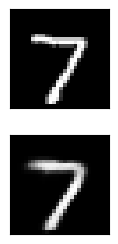

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

model.eval()
fig = plt.figure(figsize=(15, 6))
for x, t in test_dataloader:
    for i, img in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
        ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
        ax.imshow(img, 'gray')
    x = x.to(device)

    y, z = model(x)
    y = y.view(-1, 28, 28)
    for i, img in enumerate(y.cpu().detach().numpy()[:10]):
        ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
        ax.imshow(img, 'gray')
    break

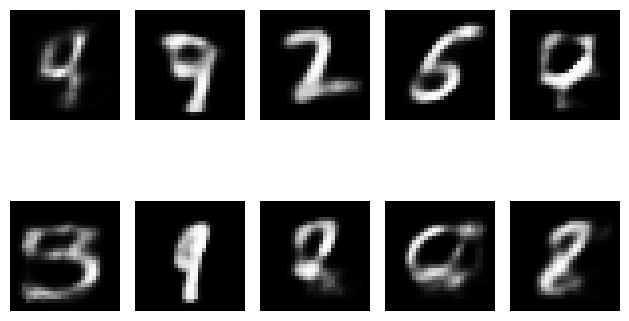

In [15]:
batch_size = 10
z = torch.randn(batch_size, 10, device=device)
model.eval()
images = model.decoder(z)

images = images.view(-1, 28, 28)
images = images.detach().cpu().numpy()

for i, image in enumerate(images):
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='binary_r')
    plt.axis('off')
plt.tight_layout()
plt.show()